In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# # download the names.txt file from github
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# Utility function to compare manual gradiants with pytorch gradinats
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3454, grad_fn=<NegBackward0>)

In [10]:
# backprob through logprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [11]:
# backprop probs -> local derivative of log * chain rule of dlogprobs
dprobs = (1.0 / probs) * dlogprobs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [12]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [13]:
# backprop through count_sum_inv
# note the broadcasting on counts_sum_inv (backprob through replication, branching through graph vis.)
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
cmp('count_sum_inv', dcounts_sum_inv, counts_sum_inv)

count_sum_inv   | exact: True  | approximate: True  | maxdiff: 0.0


In [14]:
# backprop through counts -> which contributes to 2 branches.
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [15]:
# backprop through dcounts in second branch (so we need to add them up.)
print('counts_sum vs. counts shapes', counts_sum.shape, counts.shape)
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

counts_sum vs. counts shapes torch.Size([32, 1]) torch.Size([32, 27])
counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [16]:
# backprop through norm_logits
dnorm_logits = counts * dcounts  # norm_logits.exp() * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
# backprop through dlogits
print("logits vs. logits_maxes", logits.shape, logit_maxes.shape)
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True)
cmp('dlogits_maxes', dlogit_maxes, logit_maxes)

logits vs. logits_maxes torch.Size([32, 27]) torch.Size([32, 1])
dlogits_maxes   | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
# another branch of dlogits
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [19]:
# backprop through the Linear layer 2
print(h.shape, dlogits.shape, W2.shape, b2.shape) # think through matching the shape in logits = h @ W2 + b2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('db2', db2, b2)

torch.Size([32, 64]) torch.Size([32, 27]) torch.Size([64, 27]) torch.Size([27])
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
# backprop through hpreact
dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


In [21]:
# backprop through bngain -> hpreact = bngain * bnraw + bnbias
print(hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape)
dbngain = (dhpreact * bnraw).sum(0, keepdims=True)
dbnraw = bngain * dhpreact 
dbnbias = dhpreact.sum(0, keepdims=True)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)

torch.Size([32, 64]) torch.Size([1, 64]) torch.Size([32, 64]) torch.Size([1, 64])
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


In [22]:
# backprop through batch-norm layer -> bnraw = bndiff * bnvar_inv
print(bnvar_inv.shape, dbnraw.shape, bndiff.shape)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbndiff = dbnraw * bnvar_inv
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bndiff', dbndiff, bndiff) # cause we just backpropagated through one branch.

torch.Size([1, 64]) torch.Size([32, 64]) torch.Size([32, 64])
bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0
bndiff          | exact: False | approximate: False | maxdiff: 0.0011646576458588243


In [23]:
# backprop through bnvar -> bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


In [24]:
# backprop through bnvar -> bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
print(bndiff.shape, bnvar.shape)
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

torch.Size([32, 64]) torch.Size([1, 64])
bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
# backprop through the second branch of bndiff
dbndiff += (2*bndiff) * dbndiff2
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


In [26]:
# backprop through -> bndiff = hprebn - bnmeani
# print(dbndiff.shape, hprebn.shape, bnmeani.shape)
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0
hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


In [27]:
## backprop through -> hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [28]:
# backprop through -> embcat = emb.view(emb.shape[0], -1)
print(embcat.shape, emb.shape)
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

torch.Size([32, 30]) torch.Size([32, 3, 10])
emb             | exact: True  | approximate: True  | maxdiff: 0.0


In [29]:
# backprop through -> emb = C[Xb]
print(emb.shape, C.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
cmp('C', dC, C)

torch.Size([32, 3, 10]) torch.Size([27, 10])
C               | exact: True  | approximate: True  | maxdiff: 0.0


In [30]:
# before:
# forward pass
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# after
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.345388412475586 diff: 0.0


In [31]:
# after: backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1.0
dlogits /= n
cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [34]:
# what is dlogits?
print(logits.shape, Yb.shape)
F.softmax(logits, 1)[0]

torch.Size([32, 27]) torch.Size([32])


tensor([0.0670, 0.0919, 0.0181, 0.0463, 0.0190, 0.0798, 0.0239, 0.0352, 0.0188,
        0.0327, 0.0348, 0.0393, 0.0369, 0.0288, 0.0334, 0.0142, 0.0093, 0.0193,
        0.0176, 0.0541, 0.0488, 0.0210, 0.0260, 0.0748, 0.0630, 0.0241, 0.0220],
       grad_fn=<SelectBackward0>)

In [35]:
dlogits[0] * n 

tensor([ 0.0670,  0.0919,  0.0181,  0.0463,  0.0190,  0.0798,  0.0239,  0.0352,
        -0.9812,  0.0327,  0.0348,  0.0393,  0.0369,  0.0288,  0.0334,  0.0142,
         0.0093,  0.0193,  0.0176,  0.0541,  0.0488,  0.0210,  0.0260,  0.0748,
         0.0630,  0.0241,  0.0220], grad_fn=<MulBackward0>)

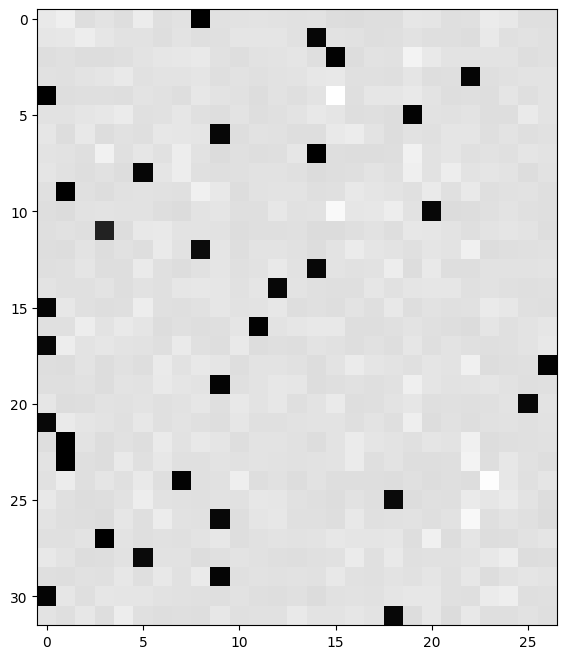

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='grey')

In [39]:
# backporp through batchnorm all in one go.
# forward pass
# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now: 
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True)) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(3.4094e-05, grad_fn=<MaxBackward1>)


In [41]:
# backward pass
# calculate dhprebn given dhpreact
# now:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('dhprebn', dhprebn, hprebn)

dhprebn         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [42]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):    
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.8058
  10000/ 200000: 2.1471
  20000/ 200000: 2.3857
  30000/ 200000: 2.5121
  40000/ 200000: 2.0065
  50000/ 200000: 2.3200
  60000/ 200000: 2.3553
  70000/ 200000: 2.0166
  80000/ 200000: 2.3658
  90000/ 200000: 2.1308
 100000/ 200000: 2.0073
 110000/ 200000: 2.3660
 120000/ 200000: 1.9809
 130000/ 200000: 2.4953
 140000/ 200000: 2.2772
 150000/ 200000: 2.1011
 160000/ 200000: 1.9516
 170000/ 200000: 1.7972
 180000/ 200000: 1.9646
 190000/ 200000: 1.9142


In [43]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [44]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070317268371582
val 2.106351613998413


In [45]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmaheam.
jhavi.
kimrix.
taty.
skanden.
jazhnte.
den.
arciereni.
nellara.
chaiha.
kaleigh.
ham.
joce.
quintes.
lilea.
jadbi.
waythogiefrynix.
kaellissa.
med.
edi.
